# Safe Path Plan using Potential Field Method


<a id='index-0'></a>

$\textbf{Potential Field Method}$

The potential function approach directs a unmanned ground vehicle (UGV) similar to a particle moving in a gradient vector field. Gradients can be intuitively viewed as forces acting on a positively charged particle UGV which is attracted to the negatively charged goal.

Obstacles also have a positive charge which forms a repulsive force directing the UGV away from obstacles. The combination of repulsive and attractive forces hopefully directs the UGV from the start location to the goal location while avoiding obstacles and threats. 

$\underline{\textbf{Setting the Environment}}$

Here we accept that straight line between the starting point $q_S$ and $q_G$ is the shortest and best path of the UGV if there are no obstacles or threats.  Here we consider obstacles as passive objects with no effect beyond there perimeter and threats as active elements with long range effects. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

$\textbf{Tuning Parameters}$

In [2]:
# 
APG = 5.0  # attractive potential gain
RPG = 100.0  # repulsive potential gain
P_AREA_WIDTH = 30.0  # potential area width [m]

Calculate gradient of Attractive Potential at point q, 
\begin{align}
\ ∇U_{att}(q) = \frac{\sigma}{2}\ x \ d(G,X)^2 \\
\end{align}

In [3]:
def xy_attractive_potential(x, y, gx, gy):
    return 0.5 * APG * np.hypot(x - gx, y - gy)

Calculate gradient of Repulsive Potential at point q, 
\begin{align}
 ∇U_{rep}(q) = \frac{\eta}{2}\ x (\frac{1}{\rho} - \frac{1}{\rho_{o}})^2 \\
\end{align}

In [4]:
def xy_repulsive_potential(x, y, ox, oy, rr):
    # search nearest obstacle
    minid = -1
    dmin = float("inf")
    for i, _ in enumerate(ox):
        d = np.hypot(x - ox[i], y - oy[i])
        if dmin >= d:
            dmin = d
            minid = i

    # calc repulsive potential
    dq = np.hypot(x - ox[minid], y - oy[minid])

    if dq <= rr:
        if dq <= 0.1:
            dq = 0.1

        return 0.5 * RPG * (1.0 / dq - 1.0 / rr) ** 2
    else:
        return 0.0

Calculate Overal Potential at Point q, 
\begin{align}
\ U(q)  = U_{att}(q) + U_{rep}(q) \\
\\
F(q) = −∇U(q)\\
\end{align}



In [5]:
def calc_potential_field(gx, gy, ox, oy, reso, rr):
    minx = min(ox) - P_AREA_WIDTH / 2.0
    miny = min(oy) - P_AREA_WIDTH / 2.0
    maxx = max(ox) + P_AREA_WIDTH / 2.0
    maxy = max(oy) + P_AREA_WIDTH / 2.0
    xw = int(round((maxx - minx) / reso))
    yw = int(round((maxy - miny) / reso))

    # calc each potential
    pmap = [[0.0 for i in range(yw)] for i in range(xw)]

    for ix in range(xw):
        x = ix * reso + minx

        for iy in range(yw):
            y = iy * reso + miny
            ug = xy_attractive_potential(x, y, gx, gy)
            uo = xy_repulsive_potential(x, y, ox, oy, rr)
            uf = ug + uo
            pmap[ix][iy] = uf

    return pmap, minx, miny

$\textbf{Motion Dynamics}$

$$
\dot x = v\,\cos(\theta)\\
\dot y = v\,\sin(\theta)\\
\dot {\theta} = \omega\\
$$

Motion model is, 
$$
X_{t+1} = FX_t + BU_t\\
$$ where

$$F = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 \\
\end{bmatrix}$$

$$B = \begin{bmatrix}
\cos(\theta)dt & 0\\
\sin(\theta)dt & 0\\
0 & dt \\
1 & 0  \\
\end{bmatrix}$$ where dt is a time interval. 

Jacobian matrix of F is, 
$$J_F = \begin{bmatrix}
\frac{dx}{dx} & \frac{dx}{dy} & \frac{dx}{d\theta} & \frac{dx}{dv} \\
\frac{dy}{dx} & \frac{dy}{dy} & \frac{dy}{d\theta} & \frac{dy}{dv} \\
\frac{d\theta}{dx} & \frac{d\theta}{dy} & \frac{d\theta}{d\theta} & \frac{d\theta}{dv} \\
\frac{dv}{dx} & \frac{dv}{dy} & \frac{dv}{d\theta} & \frac{dv}{dv} \\
\end{bmatrix}$$

$$= \begin{bmatrix}
1 & 0 & -v\sin(\theta)dt & v\cos(\theta)dt \\
0 & 1 & v\cos(\theta)dt & \sin(\theta)dt \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}$$


In [15]:
def motion_model(x, u):
    DT = 0.1  # time tick [s]
    F = np.array([[1.0, 0, 0, 0],
                  [0, 1.0, 0, 0],
                  [0, 0, 1.0, 0],
                  [0, 0, 0, 0]])

    B = np.array([[DT * math.cos(x[2, 0]), 0],
                  [DT * math.sin(x[2, 0]), 0],
                  [0.0, DT],
                  [1.0, 0.0]])

    x = F.dot(x) + B.dot(u)
    return x

Simplified Motion Model

In [1]:
def get_motion_model():
    # dx, dy
    motion = [[1, 0],
              [0, 1],
              [-1, 0],
              [0, -1],
              [-1, -1],
              [-1, 1],
              [1, -1],
              [1, 1]]

    return motion

Each duets represent one direction:
The change on the x-coordinate: can be -1 (going left), 0 (not moving along the X axis), (going right)
The simultaneous change on the y-coordinate: can be -1 (going up), 0 (not moving along the Y axis), 1 (going down)

$ \textit{Draw Heat Map}$

In [8]:
def draw_heatmap(data):
    data = np.array(data).T
    plt.pcolor(data, vmax=200.0, cmap=plt.cm.Blues)

$\underline{\textbf{Create Overall Potential Field}}$

$\textbf{Gradient Descent}$

As depicted in algorithm as shown below, it simply starts at an initial point and then repeatedly takes a step opposite to the gradient direction of the function at the current point, selecting the next minimum. 

Gradient Descent Algorithm:

$
– q(0)=qstart  \\
– i = 0  \\
– while || ∇ U(q(i)) || > ε do \\
 • q(i+1) = q(i) - α(i) ∇ U(q(i))  \\
 • i=i+1 \\
$



Ideally, one would choose $q_0$ to be close to the minimum. In our case, we have to choose the starting point $S_x, S_y$. 

When we stop iterating depends on the problem setting.
Ideally, we stop when $f(q_k)$ is 'close enough' to the minimum. What is 'close enough' depends on the situation at hand.

However, there are reasons to stop before that happens, a technique known as $\textbf{early stopping}$.

In [13]:
def potential_field_planning(sx, sy, gx, gy, ox, oy, reso, rr):

    # calc potential field
    pmap, minx, miny = calc_potential_field(gx, gy, ox, oy, reso, rr)

    # search path
    d = np.hypot(sx - gx, sy - gy)
    ix = round((sx - minx) / reso)
    iy = round((sy - miny) / reso)
    gix = round((gx - minx) / reso)
    giy = round((gy - miny) / reso)

    draw_heatmap(pmap)
    plt.plot(ix, iy, "*k")
    plt.plot(gix, giy, "*m")

    rx, ry = [sx], [sy]
    motion = get_motion_model()
    while d >= reso:
        minp = float("inf")
        minix, miniy = -1, -1
        for i, _ in enumerate(motion):
            inx = int(ix + motion[i][0])
            iny = int(iy + motion[i][1])
            if inx >= len(pmap) or iny >= len(pmap[0]):
                p = float("inf")  # outside area
            else:
                p = pmap[inx][iny]
            if minp > p:
                minp = p
                minix = inx
                miniy = iny
        ix = minix
        iy = miniy
        xp = ix * reso + minx
        yp = iy * reso + miny
        d = np.hypot(gx - xp, gy - yp)
        rx.append(xp)
        ry.append(yp)
        # CM-26Apr19
        
        #plt.plot(ix, iy, ".r")
        plt.pause(0.01)

    print("Goal!!")

    return rx, ry, pmap

$\underline{\textbf{Main Program}}$

potential_field_planning start


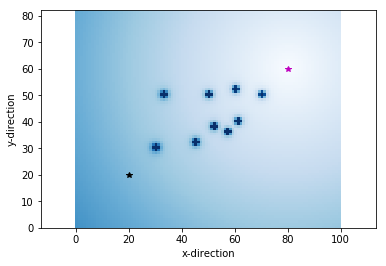

Goal!!


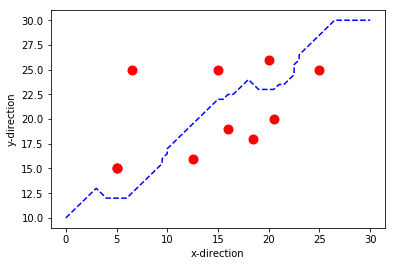

In [14]:

    print("potential_field_planning start")

    sx = 0.0  # start x position [m]
    sy = 10.0  # start y positon [m]
    gx = 30.0  # goal x position [m]
    gy = 30.0  # goal y position [m]
    grid_size = 0.5  # potential grid size [m]
    robot_radius = 5.0  # robot radius [m]

    ox = [15.0, 5.0, 20.0, 25.0, 5.0, 12.5, 20.5, 6.5, 18.5, 16.0 ]  # obstacle x position list [m]
    oy = [25.0, 15.0, 26.0, 25.0,15.0, 16.0, 20.0, 25.0, 18.0, 19.0 ]  # obstacle y position list [m]
  
    plt.grid(True)
    plt.axis("equal")
    plt.xlabel("x-direction")
    plt.ylabel("y-direction")

    # path generation
    rrx, rry, pmap = potential_field_planning(
        sx, sy, gx, gy, ox, oy, grid_size, robot_radius)

#    draw_heatmap(pmap)
   
    plt.plot(rrx, rry, "b--", ox, oy, ".r", markersize=18)
    plt.xlabel('x-direction')
    plt.ylabel('y-direction')
    plt.show();


Here we consider the best path without considering the vehicle profile or the directional angle $\theta$ of the vehicle. 

$\textit{By Dr Champ Mendis, AVS, 16-May-2019}$